In the previous module we looked at a basic prediction using only one data source and making a prediction only a few days ahead. now we will combine more data and try to make long term predictions

In [1]:
import xgboost as xgb
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error as mae
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import seaborn as sns
sns.set(rc = {'figure.figsize':(15,8)})

from prophet import Prophet # Cringe, I know


In [2]:
tavg = pd.read_csv("new_england_tavg.csv", index_col=0, parse_dates=True).squeeze("columns")
tmax = pd.read_csv("new_england_tmax.csv", index_col=0, parse_dates=True).squeeze("columns")
tmin = pd.read_csv("new_england_tmin.csv", index_col=0, parse_dates=True).squeeze("columns")
season = pd.read_csv("tavg_season_new_england.csv", index_col=0, parse_dates=True).squeeze("columns")
trend = pd.read_csv("tavg_trend_new_england.csv", index_col=0, parse_dates=True).squeeze("columns")
resid = pd.read_csv("tavg_resid_new_england.csv", index_col=0, parse_dates=True).squeeze("columns")
prcp = pd.read_csv("new_england_prcp.csv", index_col=1, parse_dates=True)
prcp = prcp["measurement"].squeeze()
tavg

date
1951-01-01   -7.01
1951-01-02   -6.75
1951-01-03   -1.29
1951-01-04    4.18
1951-01-05   -0.57
              ... 
2021-12-27   -2.83
2021-12-28   -3.98
2021-12-29   -1.90
2021-12-30   -1.52
2021-12-31    0.49
Name: measurement, Length: 25933, dtype: float64

In [3]:
target = tavg.loc["1951-01-15":].reset_index(drop=True)
target

0       -4.30
1       -1.46
2       -6.30
3       -3.87
4       -1.29
         ... 
25914   -2.83
25915   -3.98
25916   -1.90
25917   -1.52
25918    0.49
Name: measurement, Length: 25919, dtype: float64

NB: this is cheating because we created these features using the full dataset in an earlier module, thus leaking info into the training set. we will assume it's not an issue here.

In [4]:
features = [tavg, tmax, tmin, season, trend, resid, prcp]
features = pd.concat(features, axis="columns")
features.columns = ["tavg", "tmax", "tmin", "season", "trend", "resid", "prcp"]
features

,tavg,tmax,tmin,season,trend,resid,prcp
date,,,,,,,
1951-01-01,-7.01,-1.70,-12.32,-11.704722,NaN,NaN,0.33
1951-01-02,-6.75,-0.66,-12.84,-12.184425,NaN,NaN,0.00
1951-01-03,-1.29,3.95,-6.53,-12.572555,NaN,NaN,0.22
1951-01-04,4.18,7.64,0.72,-13.119966,NaN,NaN,2.43
1951-01-05,-0.57,6.57,-7.71,-13.291347,NaN,NaN,1.05
...,...,...,...,...,...,...,...
2021-12-27,-2.83,0.59,-6.25,-14.013590,NaN,NaN,0.08
2021-12-28,-3.98,0.08,-8.05,-13.877024,NaN,NaN,0.80
2021-12-29,-1.90,1.21,-5.02,-13.535091,NaN,NaN,1.97


In [5]:
features['year'] = pd.DatetimeIndex(features.index).year
features['month'] = pd.DatetimeIndex(features.index).month
features['day'] = pd.DatetimeIndex(features.index).day

In [6]:
features = features.loc[:"2021-12-17"]
features

,tavg,tmax,tmin,season,trend,resid,prcp,year,month,day
date,,,,,,,,,,
1951-01-01,-7.01,-1.70,-12.32,-11.704722,NaN,NaN,0.33,1951,1,1
1951-01-02,-6.75,-0.66,-12.84,-12.184425,NaN,NaN,0.00,1951,1,2
1951-01-03,-1.29,3.95,-6.53,-12.572555,NaN,NaN,0.22,1951,1,3
1951-01-04,4.18,7.64,0.72,-13.119966,NaN,NaN,2.43,1951,1,4
1951-01-05,-0.57,6.57,-7.71,-13.291347,NaN,NaN,1.05,1951,1,5
...,...,...,...,...,...,...,...,...,...,...
2021-12-13,2.48,5.96,-1.00,-11.732225,NaN,NaN,0.05,2021,12,13
2021-12-14,3.21,7.98,-1.56,-11.704722,NaN,NaN,0.01,2021,12,14
2021-12-15,-1.06,4.50,-6.62,-12.184425,NaN,NaN,0.00,2021,12,15


In [7]:
# train/test split
train_features, test_features, train_target, test_target = train_test_split(features, target, test_size=0.33, shuffle=False)

In [8]:
train_target

0        -4.30
1        -1.46
2        -6.30
3        -3.87
4        -1.29
         ...  
17360    17.03
17361    19.42
17362    21.50
17363    19.66
17364    19.06
Name: measurement, Length: 17365, dtype: float64

In [9]:
test_target

17365    16.25
17366    17.02
17367    18.99
17368    19.60
17369    19.84
         ...  
25914    -2.83
25915    -3.98
25916    -1.90
25917    -1.52
25918     0.49
Name: measurement, Length: 8554, dtype: float64

In [10]:
scaler = StandardScaler()


train_features_scaled = scaler.fit_transform(train_features)
test_features_scaled = scaler.fit_transform(test_features)

train_features_scaled

array([[-1.22963387, -1.22232353, -1.20482927, ..., -1.69560549,
        -1.59319485, -1.67312463],
       [-1.20498594, -1.12789451, -1.25503221, ..., -1.69560549,
        -1.59319485, -1.55947604],
       [-0.68737959, -0.70931972, -0.64583883, ..., -1.69560549,
        -1.59319485, -1.44582744],
       ...,
       [ 1.62573305,  1.64686594,  1.56019423, ...,  1.72858644,
         0.14739646, -0.08204427],
       [ 1.75655663,  1.76308628,  1.70404497, ...,  1.72858644,
         0.14739646,  0.03160432],
       [ 1.7338047 ,  1.69044857,  1.73397364, ...,  1.72858644,
         0.14739646,  0.14525292]])

In [11]:
model = xgb.XGBRegressor()
model.fit(train_features_scaled, train_target)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [12]:
predictions = model.predict(test_features_scaled)

<AxesSubplot:>

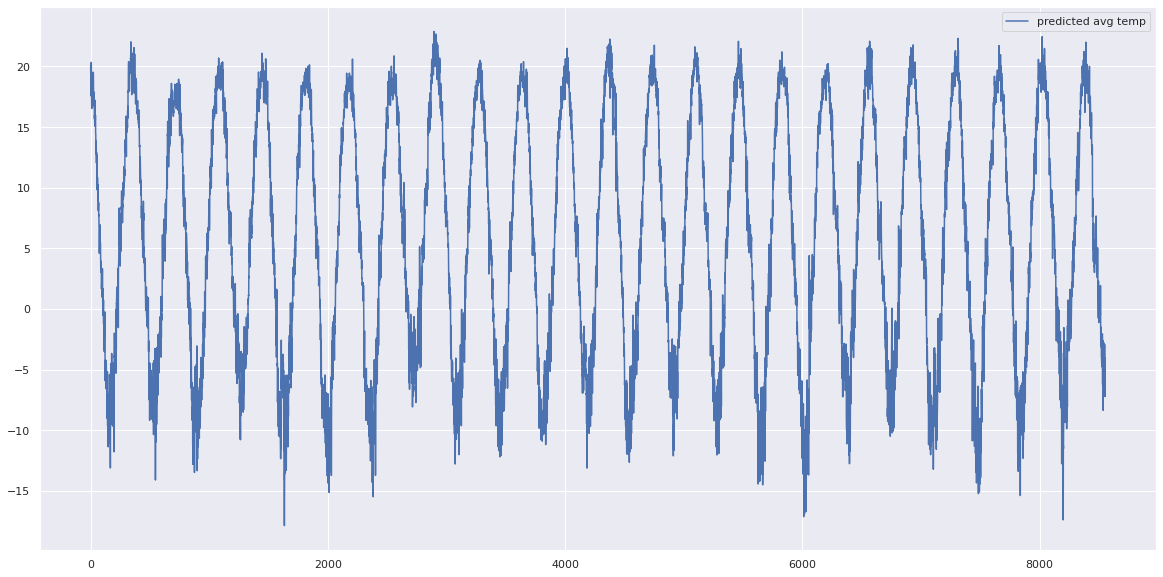

In [13]:
predictions = pd.DataFrame(predictions, columns = ["predicted avg temp"])
predictions.plot(figsize=(20,10))

<AxesSubplot:>

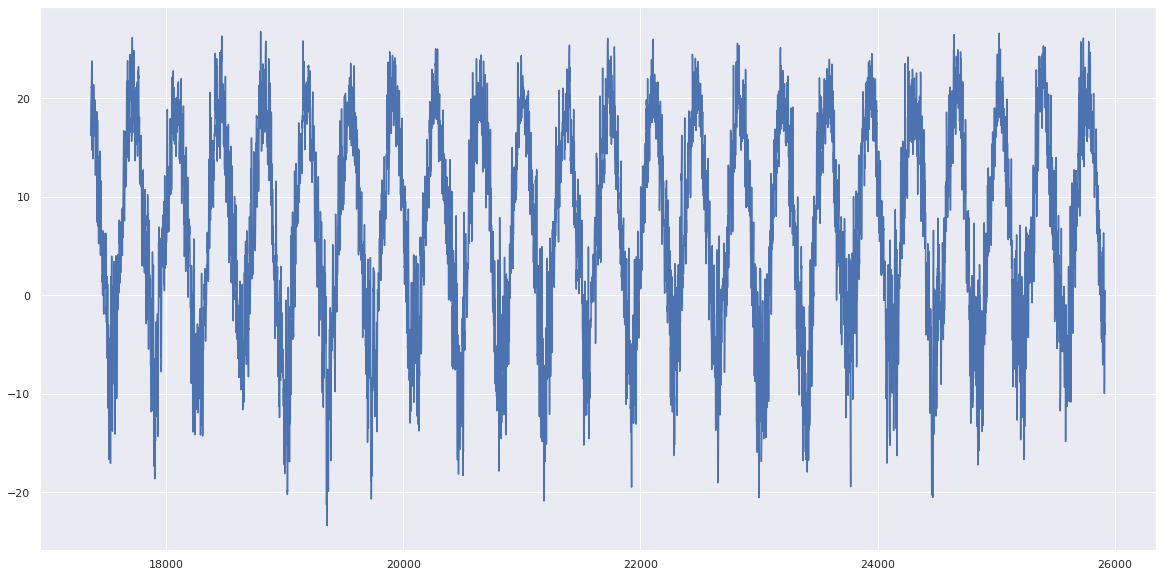

In [14]:
test_target.plot(figsize=(20,10))

In [15]:


y = test_target.reset_index(drop=True)
x = predictions["predicted avg temp"].reset_index(drop=True)

combined = pd.concat([x, y],axis="columns")
combined

,predicted avg temp,measurement
0,20.051048,16.25
1,18.433697,17.02
2,17.584969,18.99
3,19.254122,19.60
4,18.725616,19.84
...,...,...
8549,-6.702363,-2.83
8550,-4.039741,-3.98
8551,-7.220357,-1.90
8552,-6.109925,-1.52


3.534950996271562

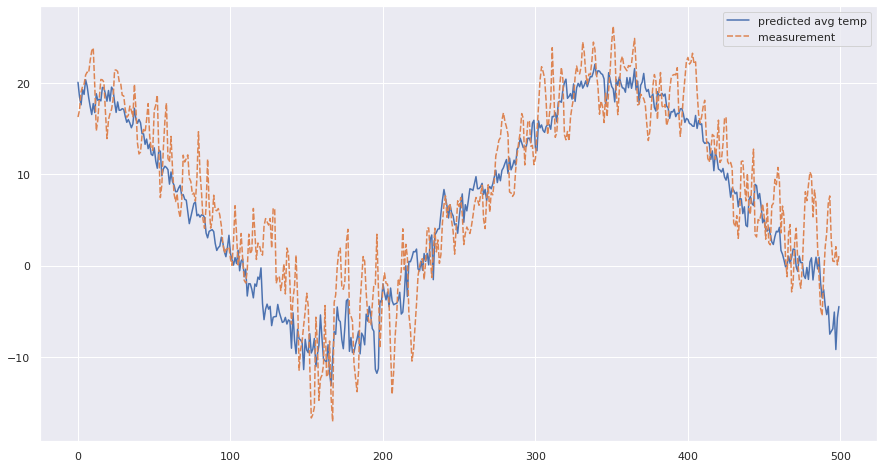

In [23]:
sns.lineplot(data=combined[:500])
mae(predictions, test_target)

In [17]:
df = pd.read_csv("new_england_tavg.csv",parse_dates=True, index_col=0)



m = Prophet()

df["ds"] = df.index
df["y"] = df["measurement"]
df = df[["ds", "y"]]

df

,ds,y
date,,
1951-01-01,1951-01-01,-7.01
1951-01-02,1951-01-02,-6.75
1951-01-03,1951-01-03,-1.29
1951-01-04,1951-01-04,4.18
1951-01-05,1951-01-05,-0.57
...,...,...
2021-12-27,2021-12-27,-2.83
2021-12-28,2021-12-28,-3.98
2021-12-29,2021-12-29,-1.90


In [18]:
m.fit(df)

17:45:48 - cmdstanpy - INFO - Chain [1] start processing
17:45:51 - cmdstanpy - INFO - Chain [1] done processing


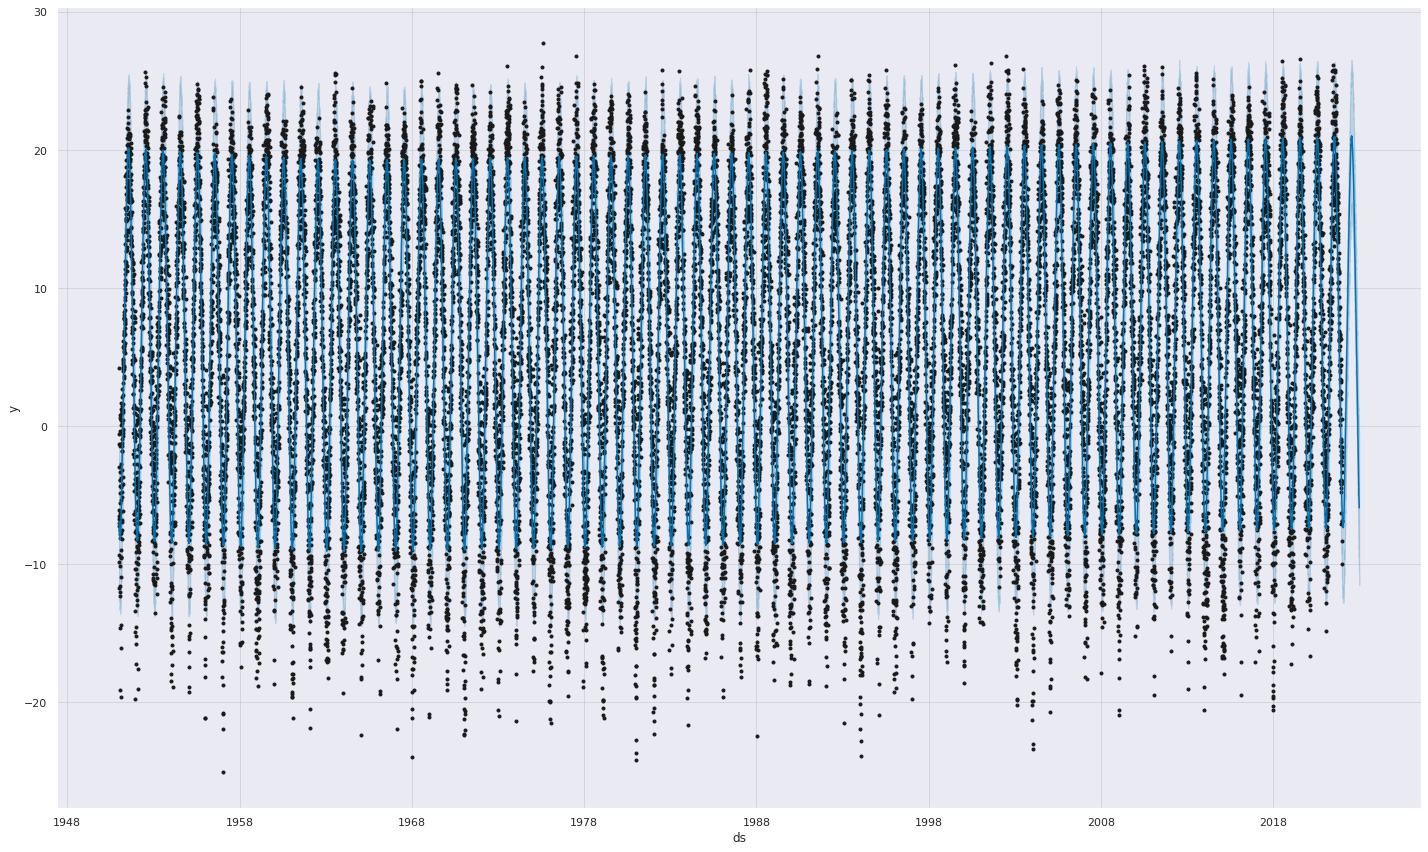

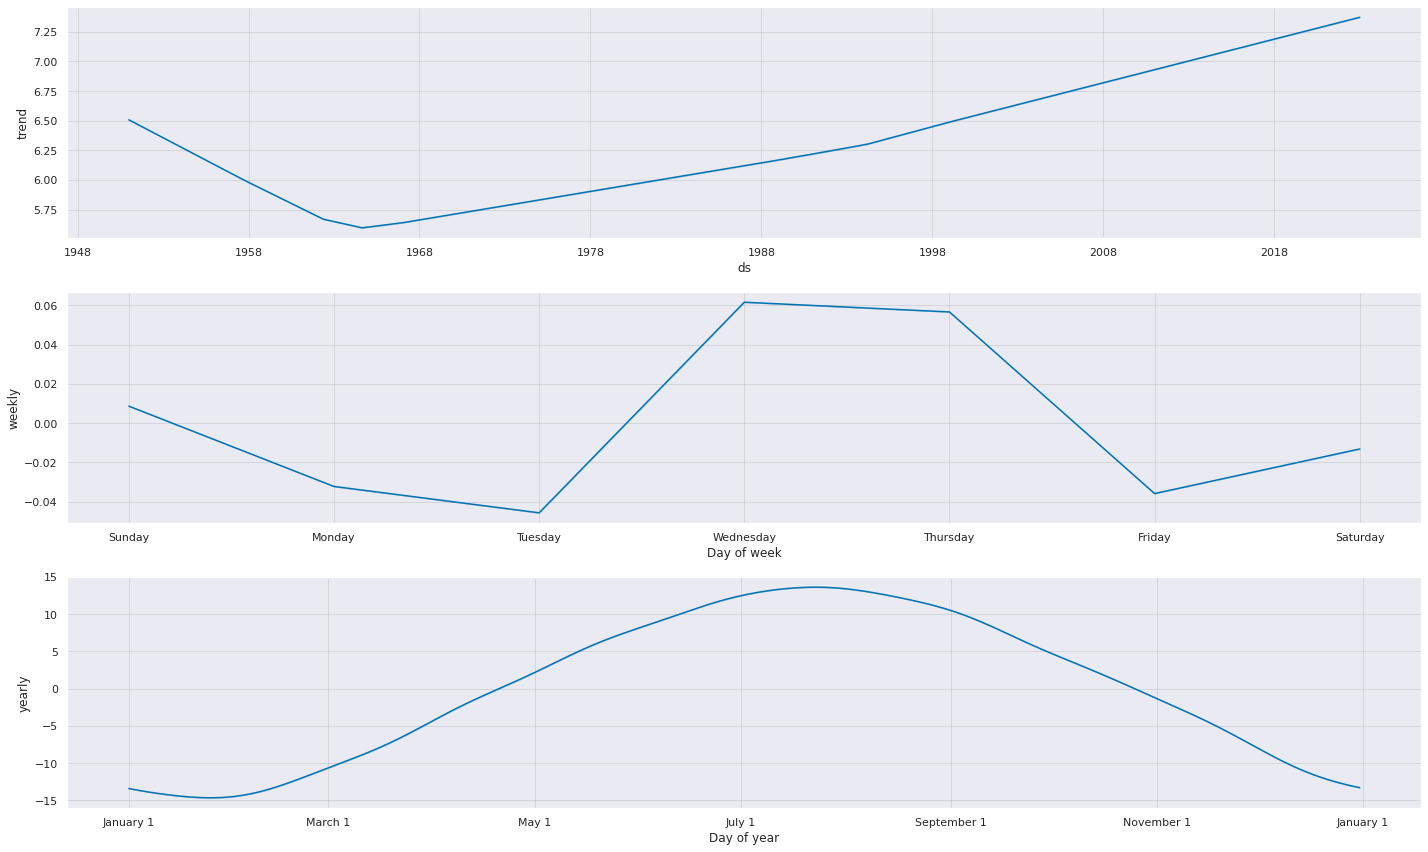

In [19]:
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)
fig1 = m.plot(forecast, figsize=(20, 12))
fig2 = m.plot_components(forecast, figsize=(20, 12))